In [ ]:
#To install the necessary packages, please run this cell:
!pip install -r pip_requirements.txt


In [2]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_tmdb_dataset
from src.utils.load_data import load_raw_data
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.lda_model import *

We are missing the step betweent the raw TMDB and the clean one?

In [ ]:
# First, run the clean_data script to clean the TMDB dataset
%run src/scripts/clean_data.py

In [4]:
# from clean data files, creates a dataframe with TMDB movies 
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')
df.info()

There should be 361,971 entries in the dataframe. 

In [5]:
df.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate es...","[action, science fiction, adventure]","[legendary pictures, syncopy, warner bros. pic...","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, fran...",2010,during
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who mak...,"[adventure, drama, science fiction]","[legendary pictures, syncopy, lynda obst produ...","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time...",2014,post
2,the dark knight,2008-07-16,1004558444,152,185000000,en,batman raises the stakes in his war on crime. ...,"[drama, action, crime, thriller]","[dc comics, legendary pictures, syncopy, isobe...","[united kingdom, united states of america]","[english, mandarin]","[joker, sadism, chaos, secret identity, crime ...",2008,during
3,avatar,2009-12-15,2923706026,162,237000000,en,"in the 22nd century, a paraplegic marine is di...","[action, adventure, fantasy, science fiction]","[dune entertainment, lightstorm entertainment,...","[united states of america, united kingdom]","[english, spanish]","[future, society, culture clash, space travel,...",2009,during
4,the avengers,2012-04-25,1518815515,143,220000000,en,when an unexpected enemy emerges and threatens...,"[science fiction, action, adventure]",[marvel studios],[united states of america],"[english, hindi, russian]","[new york city, superhero, shield, based on co...",2012,during


In [6]:
df.describe()

,revenue,runtime,budget,release_year
count,3.634420e+05,363442.000000,3.634420e+05,363442.000000
mean,1.933987e+06,66.118456,7.483577e+05,2006.758019
std,2.852904e+07,52.753540,7.753291e+06,13.088203
min,0.000000e+00,0.000000,0.000000e+00,1976.000000
25%,0.000000e+00,0.000000,0.000000e+00,1998.000000
50%,0.000000e+00,82.000000,0.000000e+00,2010.000000
75%,0.000000e+00,98.000000,0.000000e+00,2018.000000
max,2.923706e+09,500.000000,8.880000e+08,2023.000000


We see that not all movies have revenue, runtime, or budget information as they are set to zero. However, we keep these movies in our dataset as they might be associated other relevant information. For any analysis pertaining to these features, we ensure instead to exclude any movies for which their value is 0. 

To start our analysis we looked at DVD releases over time to properly define our eras. 


# DVD releases over time

In [7]:
df_dvd_releases = load_raw_data('data/processed/dvd_releases.csv')
df_dvd_releases['dvd_release_date'] = pd.to_datetime(df_dvd_releases['dvd_release_date'])
df_grouped = df_dvd_releases.resample('ME', on='dvd_release_date').size()


Loading data from data/processed/dvd_releases.csv...


In [8]:
# Calculate our eras using our data
peak_date = df_grouped.idxmax()
peak_value = df_grouped.max()
mean_releases = df_grouped.mean()
std_releases = df_grouped.std()
threshold_low = mean_releases - std_releases
threshold_high = mean_releases + std_releases

pre_dvd_end = df_grouped[df_grouped > threshold_high].index[0]  # First time crosses upper threshold
post_dvd_start = df_grouped[df_grouped > threshold_high].index[-1]  # Last time crosses upper threshold
print(f"Pre-DVD Era: Before {pre_dvd_end.strftime('%Y')}")
print(f"DVD Era: {pre_dvd_end.strftime('%Y')} to {post_dvd_start.strftime('%Y')}")
print(f"Post-DVD Era: After {post_dvd_start.strftime('%Y')}")

Pre-DVD Era: Before 1997
DVD Era: 1997 to 2013
Post-DVD Era: After 2013


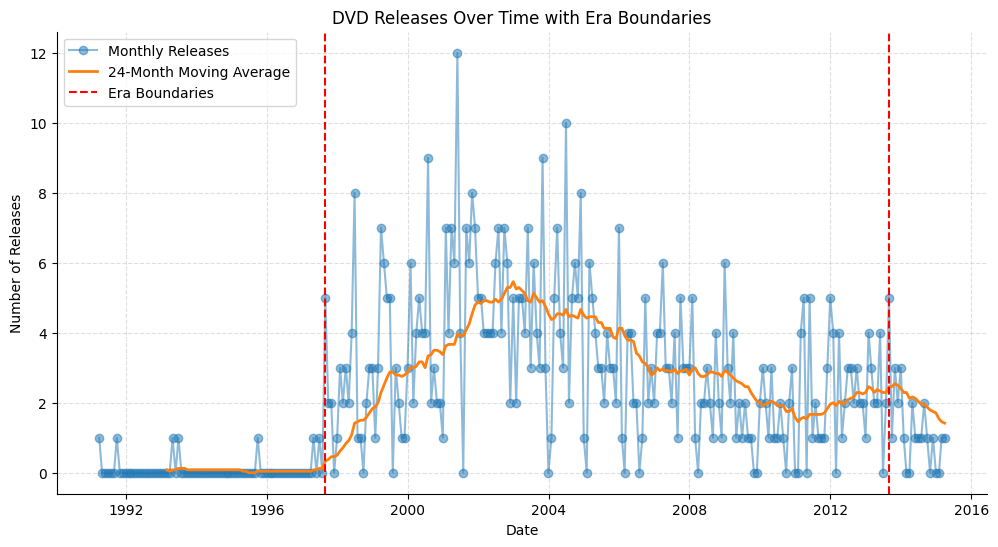

In [9]:
moving_avg = df_grouped.rolling(window=24).mean() 
plt.figure(figsize=(12, 6))

plt.plot(df_grouped.index, df_grouped.values, marker='o', alpha=0.5, label='Monthly Releases')
plt.plot(moving_avg.index, moving_avg.values, linewidth=2, label='24-Month Moving Average')

# Draw the era boundaries
plt.axvline(x=pre_dvd_end, color='r', linestyle='--', label='Era Boundaries')
plt.axvline(x=post_dvd_start, color='r', linestyle='--')

style_plot('DVD Releases Over Time with Era Boundaries', 'Date', 'Number of Releases', True)

# General Overview

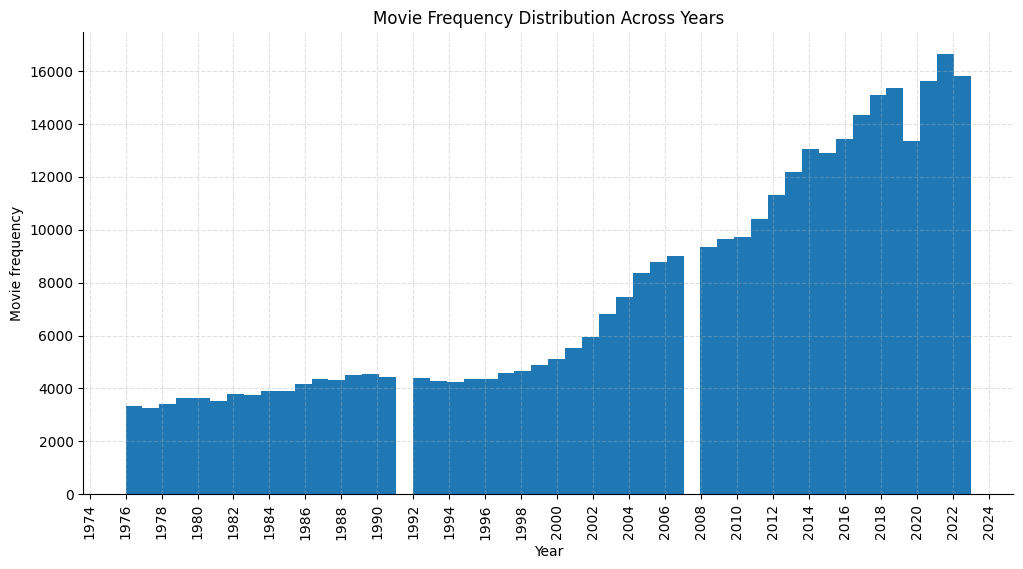

In [10]:
# Get a general distribution of movies
plt.figure(figsize=(12, 6))

plt.hist(df['release_year'], bins=50)
plt.locator_params(axis='x', nbins=50) 
plt.xticks(rotation=90)
style_plot('Movie Frequency Distribution Across Years', 'Year', 'Movie frequency')

# Revenue overview
We first obtain an overview of movie revenues, considering all movies together.

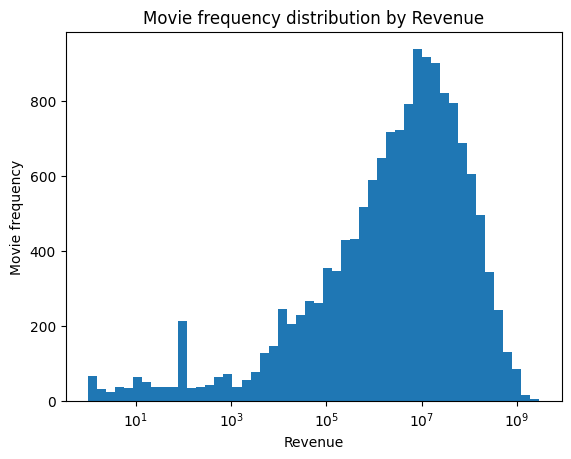

In [11]:
# Frequency distribution per budget, with budget in logscale 
plot_loghist(df[df['revenue'] > 0]['revenue'], 50, xlabel='Revenue', ylabel='Movie frequency')

We then analyse revenue by DVD eras.

In [12]:
# Summary statistics for each DVD era
print('Summary statistics of revenue for each DVD era:')
df[df.revenue > 0].groupby('dvd_era')['revenue'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of revenue for each DVD era:


dvd_era,pre,during,post
count,3.079000e+03,6.114000e+03,5.864000e+03
mean,3.269406e+07,5.134336e+07,4.916675e+07
std,7.215145e+07,1.280726e+08,1.584989e+08
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.220048e+06,5.169648e+05,1.000000e+05
50%,8.894289e+06,6.635626e+06,2.239196e+06
75%,2.917746e+07,4.198485e+07,2.027746e+07
max,9.201000e+08,2.923706e+09,2.800000e+09


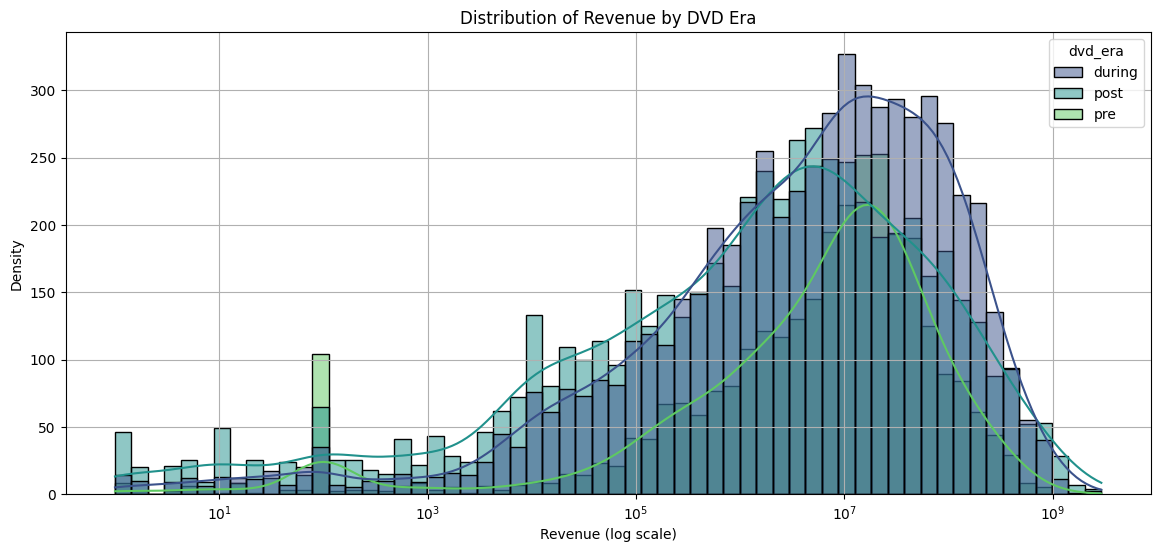

In [13]:
# Revenue per era
plot_revenue_per_era(df)

# Budget overview
We then consider budget distributions.

In [14]:
df_filtered = df[(df['budget'] > 0)]

print('Summary statistics of budget for each DVD era:')
df_filtered.groupby('dvd_era')['budget'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of budget for each DVD era:


dvd_era,pre,during,post
count,3.047000e+03,9.461000e+03,1.162200e+04
mean,1.099735e+07,1.421298e+07,8.949124e+06
std,1.488503e+07,2.888789e+07,2.972991e+07
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,6.000000e+05,2.000000e+05,3.000000e+03
50%,5.500000e+06,2.400000e+06,1.400000e+05
75%,1.500000e+07,1.400000e+07,3.500000e+06
max,1.750000e+08,3.790000e+08,8.880000e+08


We can see that most budget statistics (quantiles, median and mean) are lower in the post-DVD era, but the maximum budget is higher. 

We examine the budget trends in more details using plots. 

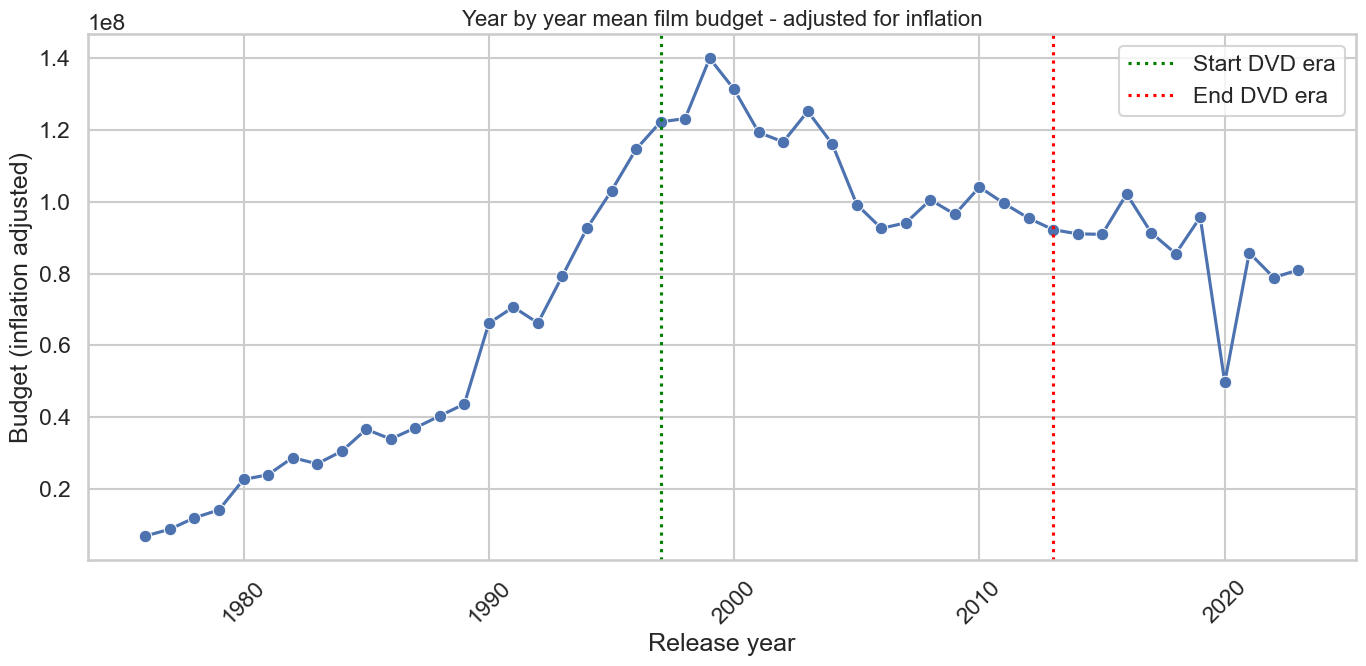

In [15]:
# Plot mean budget across time, accounting for inflation
plot_mean_budget_inflation(df)

We can use histograms to compare film budgets before, during and after the DVD era. We use a log-scale to represent movies with both small and high budgets on the same graph. This leads to the results of pre vs. post DVD era to be unreadable. 


We can nevertheless interpret the results for adjacent eras :
- Pre vs. during: before DVDs, only high budgets films were produced, with a mono-modal distribution, around 10^7 dollars budget. During the DVD era, the distribution widened, with smaller budget films being produced.
- During vs. post: after the DVD era, we see the distribution becoming more bimodal with another density maximum around 10^4 dollars.

Interpreting this is tricky : maybe more movies can become available in streaming services, pushing for smaller-budget productions.

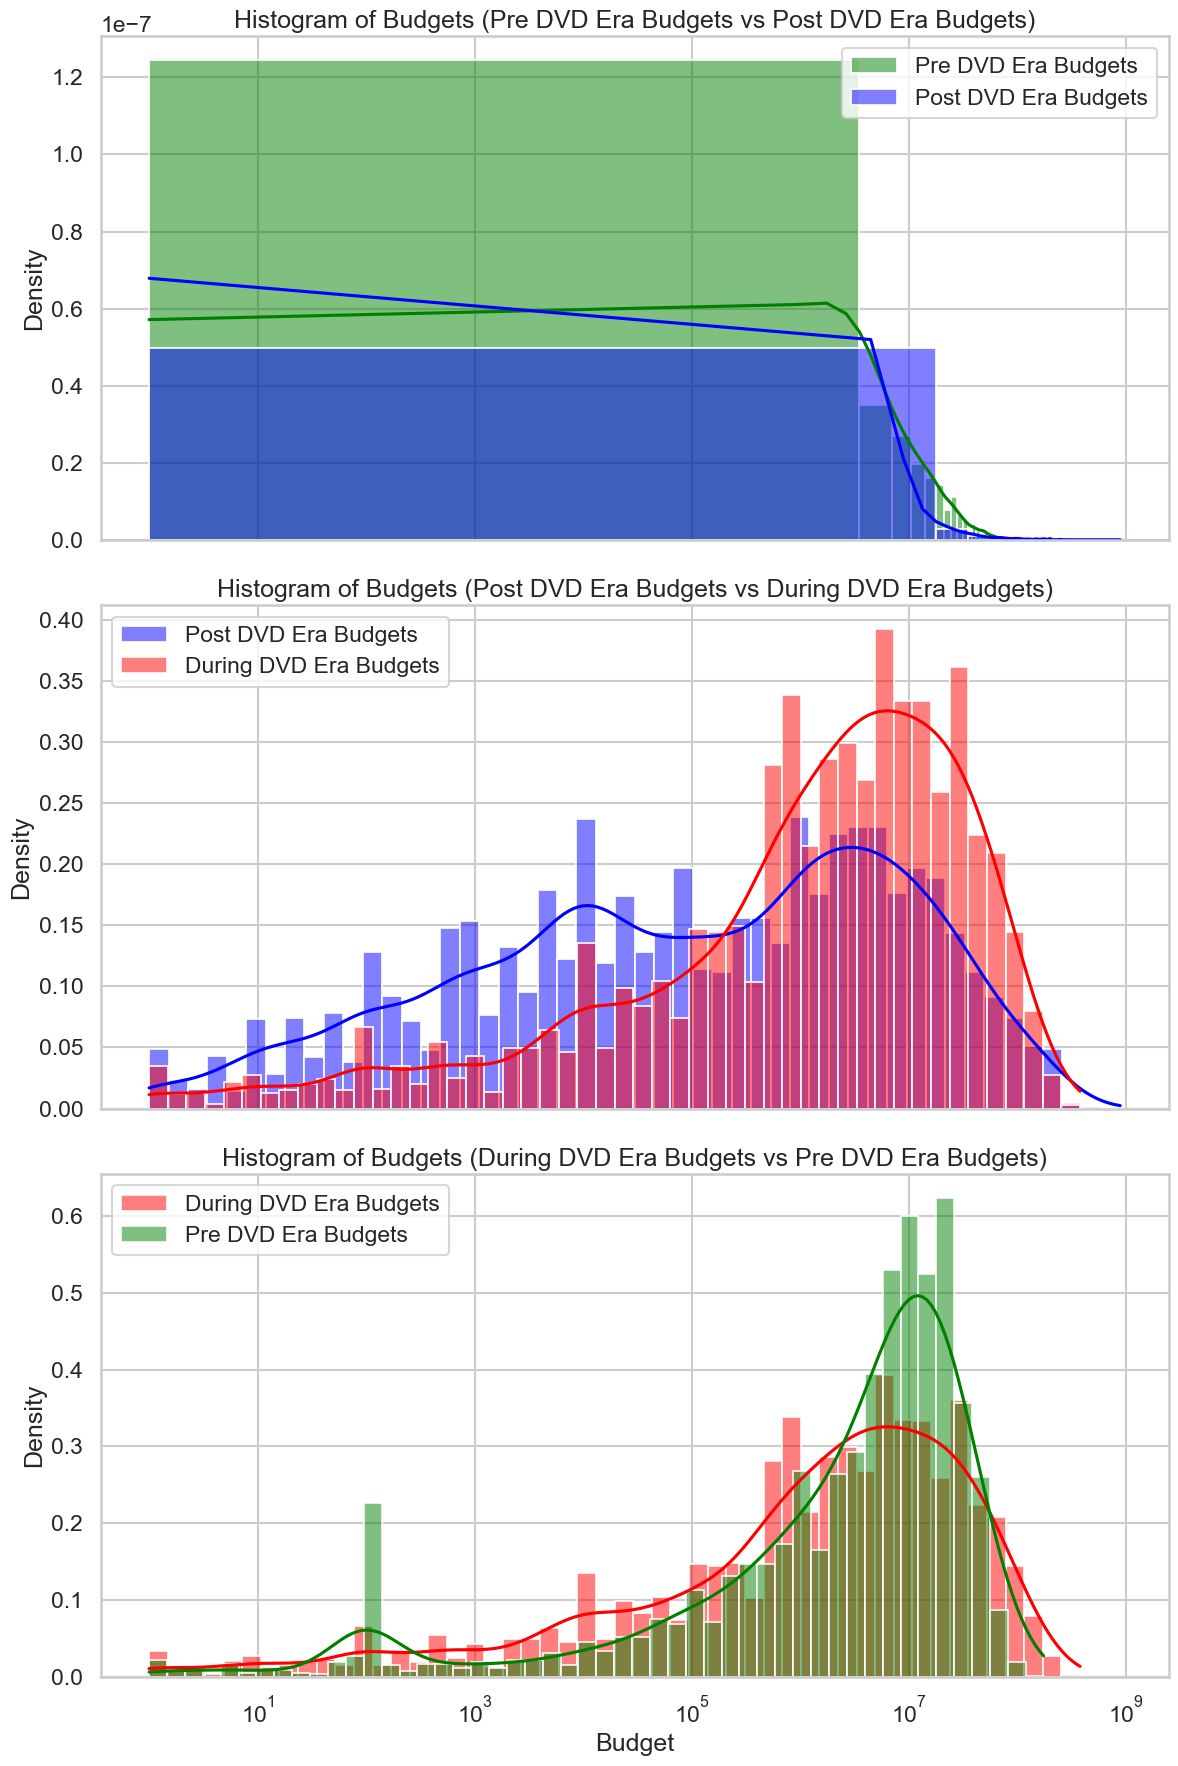

In [16]:

# Define eras, colors, and labels for the plots
eras = [("pre", "post"), ("post", "during"), ("during", "pre")]
colors = [('green', 'blue'), ('blue', 'red'), ('red', 'green')]
labels = [('Pre DVD Era Budgets', 'Post DVD Era Budgets'), 
          ('Post DVD Era Budgets', 'During DVD Era Budgets'), 
          ('During DVD Era Budgets', 'Pre DVD Era Budgets')]

# Plot histograms
plot_budget_histograms(df_filtered, eras, colors, labels, 'Histogram of Budgets')

## Production types

We categorize the movies in different types according to their budgets (compared to the mean) :
- Independent movies: less than 1/10th of the mean budget.
- Small productions: Between 1/10th and 1 of the mean budget.
- Big productions: Between 1 and 5 times the mean budget.
- Super productions More than 5 times the mean budget.

We then plot the proportion of those movies (over the total) using a 3 years rolling average.

The most interesting finding is that the DVD era seems to correspond to a loss of interest for really expensive movies. This can be explained by the fact that :
- Before DVDs, going to the cinema was exceptional, but also the only way to consume movies. So only big franchises with high production budgets could really make a lot of profit.
- After DVDs, the streaming platforms want to differentiate from each other by giving access to exceptional movies, that are really costly.

/Users/charlottemeyer/Documents/EPFL - Applied Data Analysis/ada-2024-project-databand/src/utils/data_utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'budget_category'] = df.apply(categorize_budget, args=(budget_stats,), axis=1)


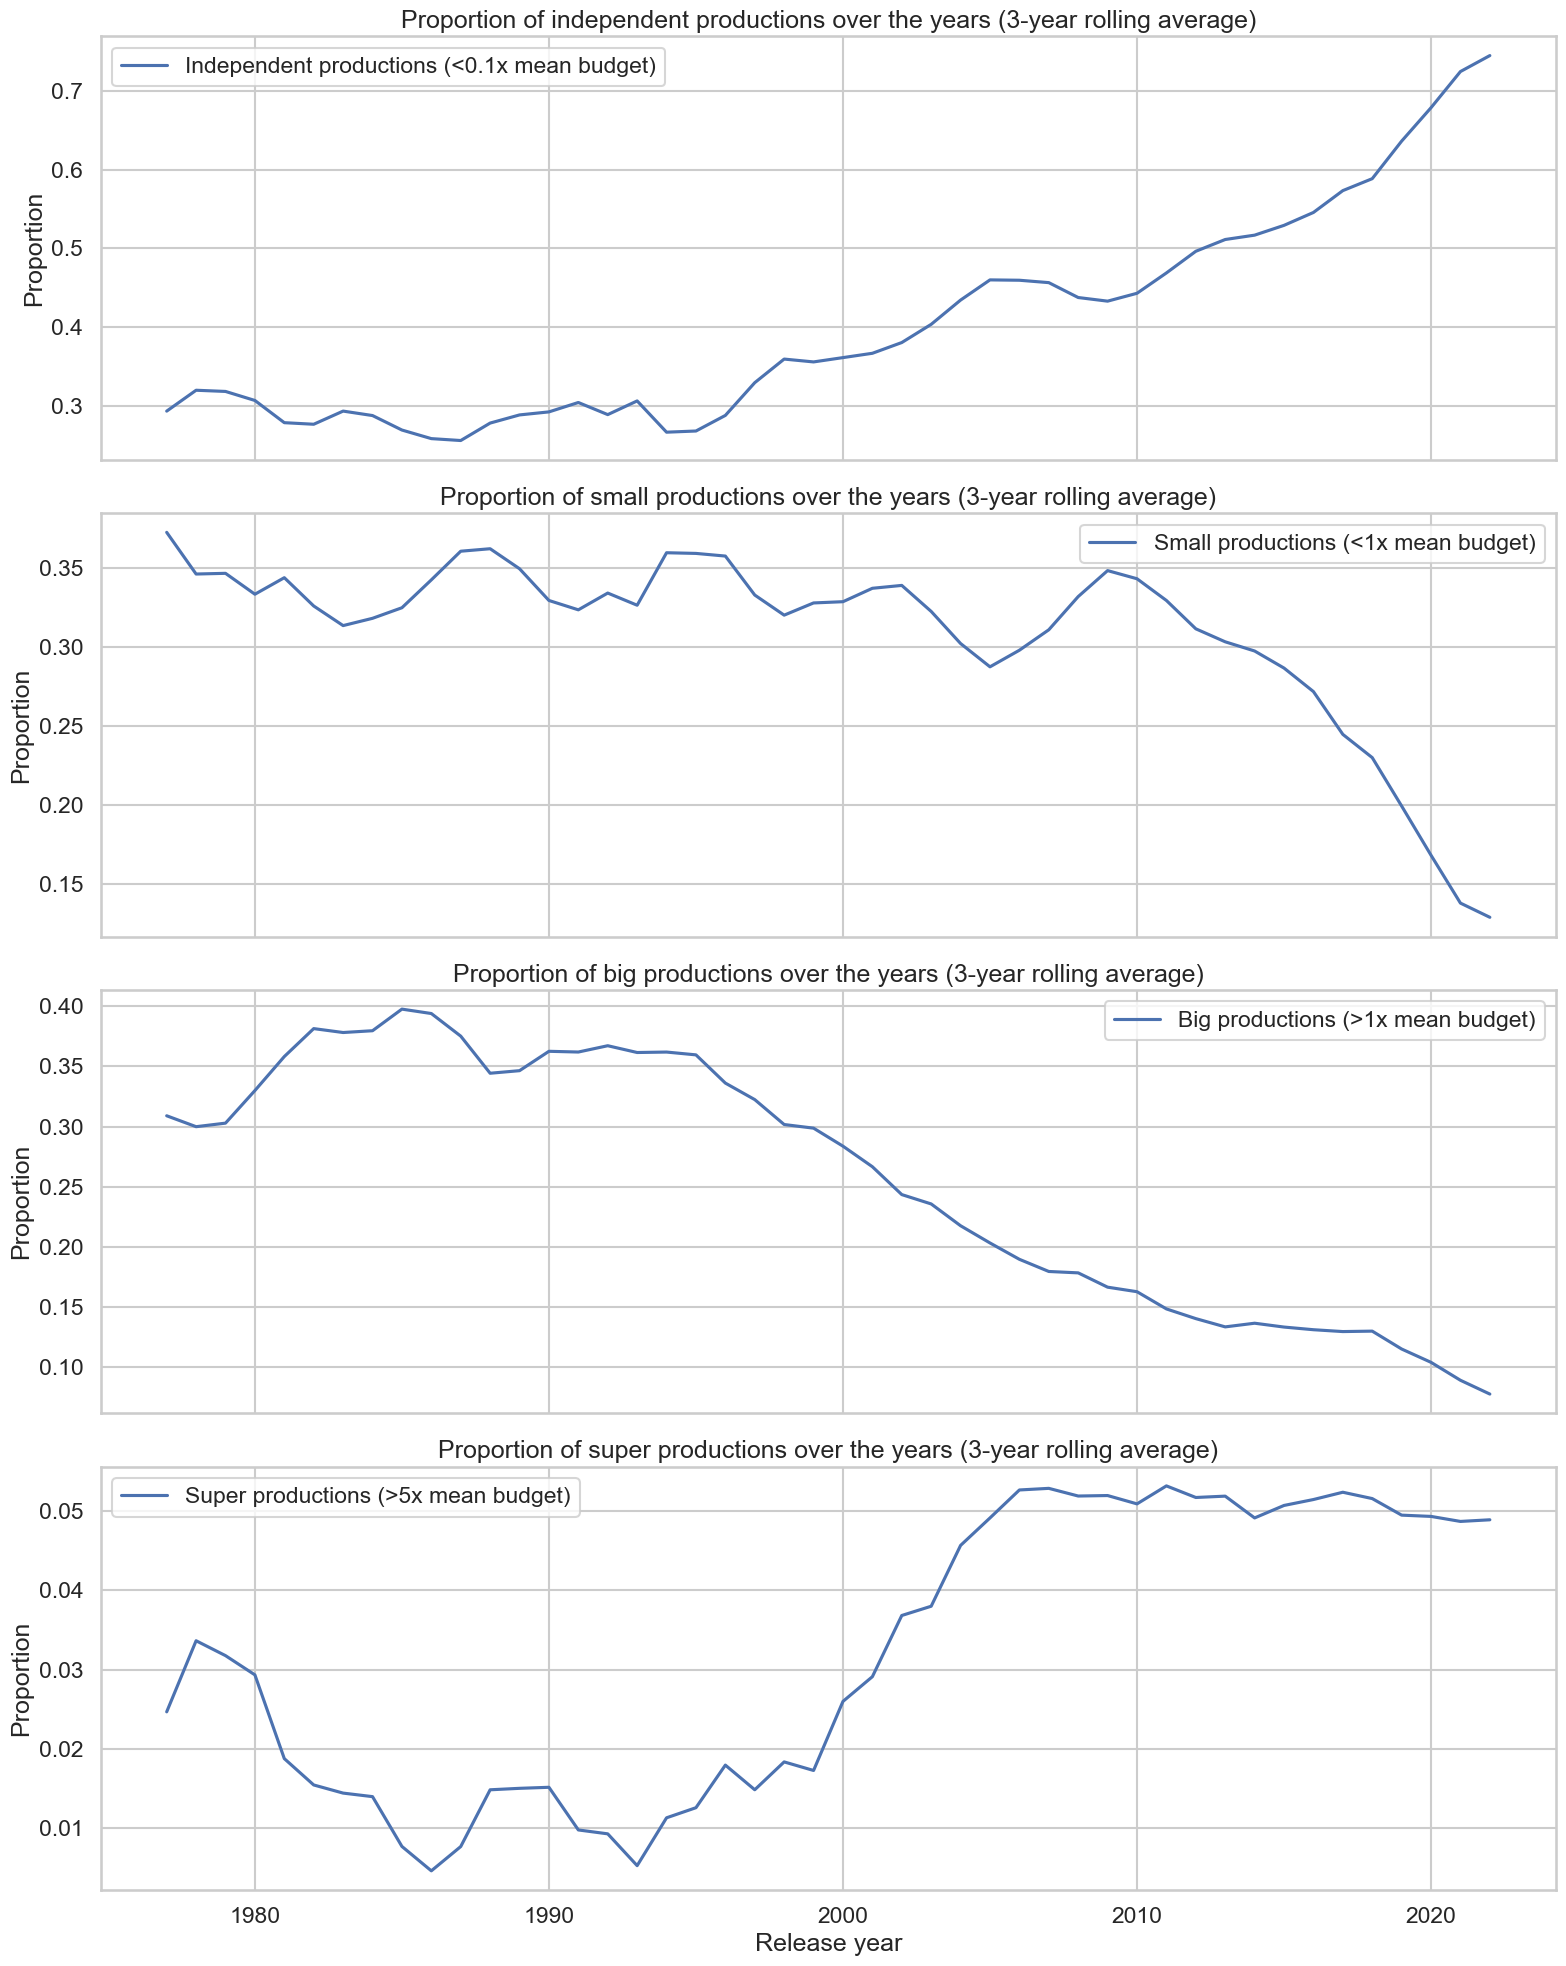

In [17]:
prop_rolling_avg = budget_rolling_averages(df_filtered, window=3)
plot_rolling_averages(prop_rolling_avg)

# Production Companies

We then take a look at production companies

In [18]:
df[(df.budget > 0) & (df.budget < 1e2)].budget.describe()


count    1441.000000
mean       25.244275
std        26.024188
min         1.000000
25%         5.000000
50%        15.000000
75%        45.000000
max        99.000000
Name: budget, dtype: float64

In [19]:
def calculate_roi(df):
    if df.revenue > 0 and df.budget > 0:
        return (df.revenue - df.budget) / df.budget * 100
    else: 
        return 0
    
df['roi'] = df.apply(calculate_roi, axis=1)

In [20]:
mean_budgets = df[df.budget > 0].groupby('release_year').agg(mean_budget = ('budget', 'mean'))

def categorize_production(row, means):
    mean_budget = means.loc[row.release_year, 'mean_budget']
    if row['budget'] < 0.1 * mean_budget:
        return 'Independent'
    elif row['budget'] < mean_budget:
        return 'Small'
    elif row['budget'] < 5 * mean_budget:
        return 'Big'
    else:
        return 'Super'
    
df['prod_type'] = df.apply(categorize_production, axis=1, args=(mean_budgets,))

<Axes: xlabel='release_year', ylabel='mean_roi'>

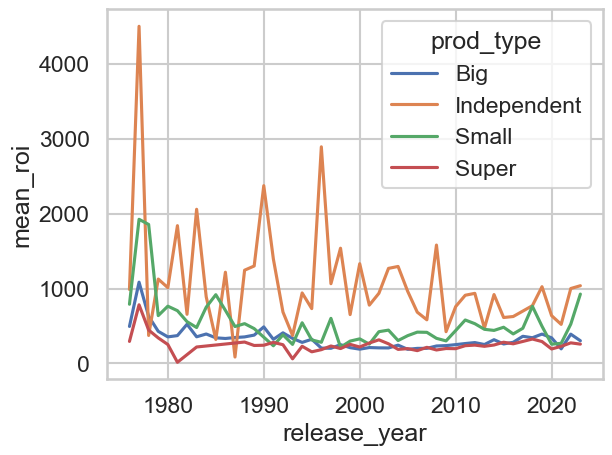

In [21]:
sns.lineplot(
    df[(df.roi > 0) & (df.roi <1e4)].groupby(['release_year', 'prod_type']).agg(mean_roi=('roi', 'mean')).reset_index(),
    x='release_year', y='mean_roi', hue='prod_type')

In [22]:
df.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era,roi,prod_type
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate es...","[action, science fiction, adventure]","[legendary pictures, syncopy, warner bros. pic...","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, fran...",2010,during,415.957978,Super
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who mak...,"[adventure, drama, science fiction]","[legendary pictures, syncopy, lynda obst produ...","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time...",2014,post,325.290428,Super
2,the dark knight,2008-07-16,1004558444,152,185000000,en,batman raises the stakes in his war on crime. ...,"[drama, action, crime, thriller]","[dc comics, legendary pictures, syncopy, isobe...","[united kingdom, united states of america]","[english, mandarin]","[joker, sadism, chaos, secret identity, crime ...",2008,during,443.004564,Super
3,avatar,2009-12-15,2923706026,162,237000000,en,"in the 22nd century, a paraplegic marine is di...","[action, adventure, fantasy, science fiction]","[dune entertainment, lightstorm entertainment,...","[united states of america, united kingdom]","[english, spanish]","[future, society, culture clash, space travel,...",2009,during,1133.631235,Super
4,the avengers,2012-04-25,1518815515,143,220000000,en,when an unexpected enemy emerges and threatens...,"[science fiction, action, adventure]",[marvel studios],[united states of america],"[english, hindi, russian]","[new york city, superhero, shield, based on co...",2012,during,590.370689,Super


In [23]:
from itertools import combinations
import networkx as nx

In [24]:
def create_edges_list(df):
    edges = []
    for companies in df['production_companies']:
        if len(companies)>1:
            edges.extend(list(combinations(companies,2)))
    # edges = list(set(edges))
    return edges


In [25]:
df_graph = df[df['production_companies'].str.len() > 0]

before_DVD_era_super = df_graph[(df_graph['dvd_era'] == 'pre') & (df_graph['prod_type'] == 'Super')]
# during_DVD_era = df_graph[df_graph['dvd_era'] == 'during']
# after_DVD_era = df_graph[df_graph['dvd_era'] == 'post']

print(before_DVD_era_super.shape)
# print(during_DVD_era.shape)
# print(after_DVD_era.shape)



(43, 16)


In [26]:
before_edges = create_edges_list(before_DVD_era_super)
# during_edges = create_edges_list(during_DVD_era)
# after_edges = create_edges_list(after_DVD_era)

In [27]:
before_edges[0]


('lightstorm entertainment', 'carolco pictures')

In [28]:

# Create the graph
G_before = nx.Graph()
# G_during = nx.Graph()
# G_after = nx.Graph()

G_before.add_edges_from(before_edges)
# G_during.add_edges_from(during_edges)
# G_after.add_edges_from(after_edges)


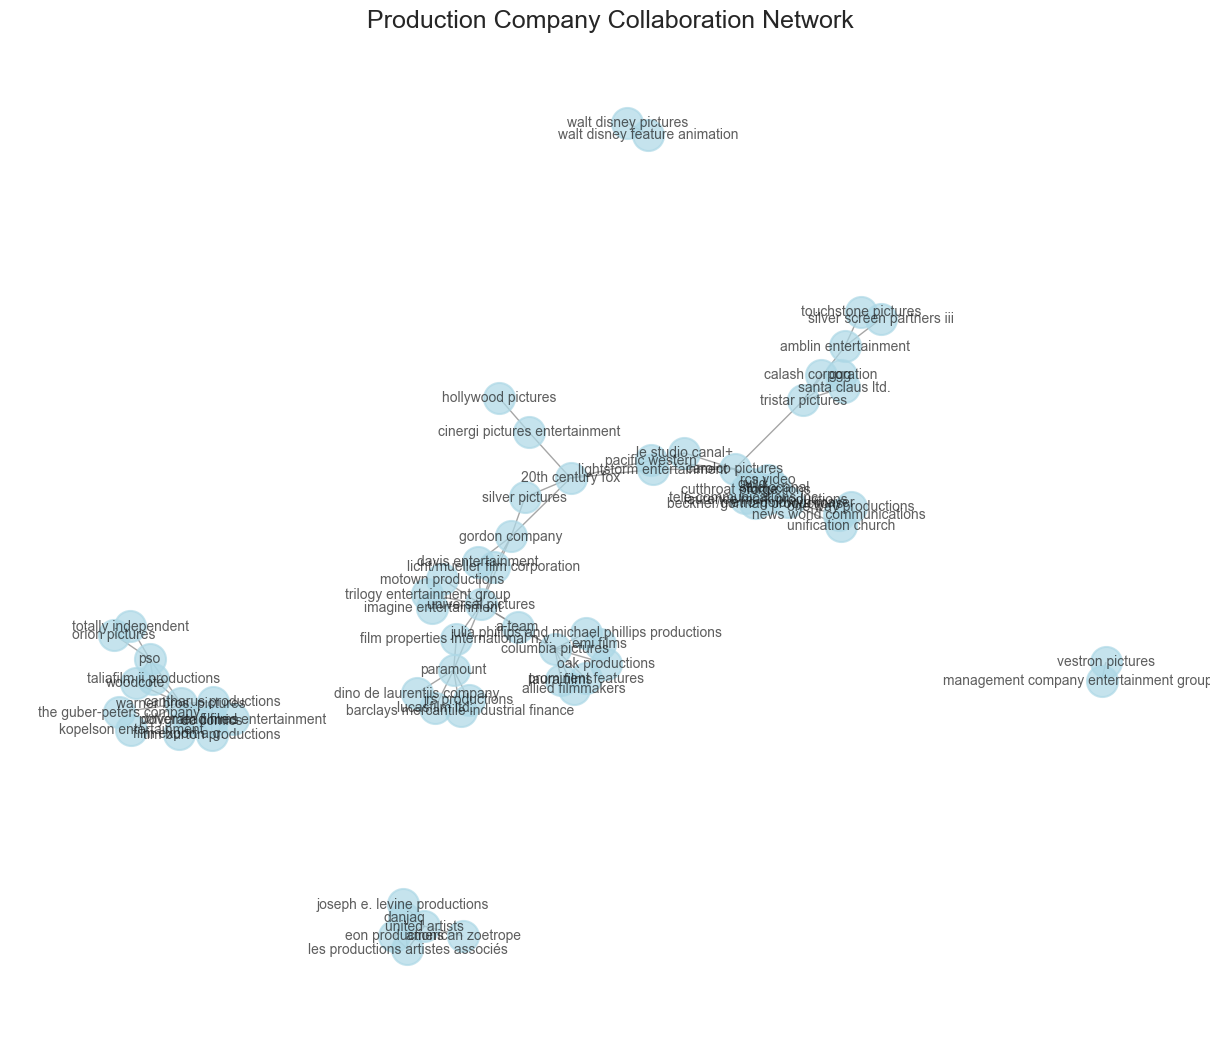

In [29]:
plt.figure(figsize=(12, 10))
nx.draw(
    G_before,
    with_labels=True,
    node_size=500,
    font_size=10,
    node_color='lightblue',     # Add color to nodes
    edge_color='gray',          # Add color to edges
    alpha=0.7,                  # Add transparency
    width=1,                    # Edge width
    pos=nx.spring_layout(G_before)  # Use spring layout for better node positioning
)
plt.title("Production Company Collaboration Network")
plt.show()

In [37]:
# from ipywidgets import interact, widgets, interactive, IntSlider, Layout
# from IPython.display import display, HTML, clear_output

# # Create a slider for years and dropdown for production type
# @interact(
#     year=IntSlider(
#         min=1976,
#         max=2023,
#         step=1,
#         value=2000,
#         description='Year:',
#         continuous_update=False,  # Only update when slider is released
#         layout=Layout(width='50%')
#     ),
#     prod_type=widgets.Dropdown(
#         options=['Super', 'Big', 'Small', 'Independent'],
#         value='Super',
#         description='Production Type:'
#     )
# )
# def plot_network_by_year(year, prod_type):
#     # Clear any previous output
#     clear_output(wait=True)
    
#     # Filter data for selected year and production type
#     df_filtered = df_graph[
#         (df_graph['release_year'].astype(int) == year) & 
#         (df_graph['prod_type'] == prod_type)
#     ]
    
#     # Create edges list
#     edges = create_edges_list(df_filtered)
    
#     # Create network
#     G = nx.Graph()
#     G.add_edges_from(edges)
    
#     # Print statistics
#     print(f"\nNetwork Statistics for {year}, {prod_type} Productions:")
#     print(f"Number of nodes (production companies): {G.number_of_nodes()}")
#     print(f"Number of edges (collaborations): {G.number_of_edges()}")
#     if G.number_of_nodes() > 0:
#         print(f"Average degree (collaborations per company): {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    
#     # Create interactive network visualization
#     net = Network(
#         height='600px',
#         width='100%',
#         bgcolor='#ffffff',
#         font_color='black',
#         cdn_resources='remote'
#     )
    
#     # Convert NetworkX graph to Pyvis
#     net.from_nx(G)
    
#     # Add physics options for better visualization
#     net.set_options("""
#     const options = {
#         "physics": {
#             "forceAtlas2Based": {
#                 "gravitationalConstant": -50,
#                 "centralGravity": 0.01,
#                 "springLength": 100,
#                 "springConstant": 0.08
#             },
#             "maxVelocity": 50,
#             "minVelocity": 0.1,
#             "solver": "forceAtlas2Based"
#         },
#         "nodes": {
#             "size": 20,
#             "font": {
#                 "size": 12
#             },
#             "borderWidth": 2
#         },
#         "edges": {
#             "width": 1,
#             "smooth": {
#                 "type": "continuous"
#             }
#         }
#     }
#     """)
    
#     # Save and display the graph
#     filename = f"graph_{year}_{prod_type.lower()}.html"
#     net.show(filename)
    
#     # Display the graph in the notebook
#     with open(filename, 'r', encoding='utf-8') as f:
#         html_content = f.read()
#     display(HTML(html_content))

In [31]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [33]:
from ipywidgets import interact, widgets, IntSlider, Layout
import matplotlib.pyplot as plt
import networkx as nx

@interact(
    year=IntSlider(
        min=1976,
        max=2023,
        step=1,
        value=2000,
        description='Year:',
        continuous_update=False,
        layout=Layout(width='50%')
    ),
    prod_type=widgets.Dropdown(
        options=['Super', 'Big', 'Small', 'Independent'],
        value='Super',
        description='Production Type:'
    )
)
def plot_network_by_year(year, prod_type):
    # Clear previous plot
    plt.clf()
    
    # Filter data
    df_filtered = df_graph[
        (df_graph['release_year'].astype(int) == year) & 
        (df_graph['prod_type'] == prod_type)
    ]
    
    # Create edges list
    edges = create_edges_list(df_filtered)
    
    # Create network
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Calculate network layout
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw the network
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=1000,
        font_size=8,
        font_weight='bold',
        edge_color='gray',
        width=0.5,
        alpha=0.7
    )
    
    # Add title with statistics
    plt.title(f"Production Company Network - {year} ({prod_type} Productions)\n" +
              f"Companies: {G.number_of_nodes()}, " +
              f"Collaborations: {G.number_of_edges()}, " +
              f"Avg. Collaborations per Company: {2*G.number_of_edges()/G.number_of_nodes():.2f}" if G.number_of_nodes() > 0 else "No data",
              pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    if G.number_of_nodes() > 0:
        print("\nTop 5 Companies by Number of Collaborations:")
        degrees = dict(G.degree())
        top_companies = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
        for company, degree in top_companies:
            print(f"{company}: {degree} collaborations")

interactive(children=(IntSlider(value=2000, continuous_update=False, description='Year:', layout=Layout(width=…

In [34]:
from ipywidgets import interact, widgets, IntSlider, Layout
import matplotlib.pyplot as plt
import networkx as nx

@interact(
    year=IntSlider(
        min=1976,
        max=2023,
        step=1,
        value=2000,
        description='Year:',
        continuous_update=False,
        layout=Layout(width='50%')
    ),
    prod_type=widgets.Dropdown(
        options=['Super', 'Big', 'Small', 'Independent'],
        value='Super',
        description='Production Type:'
    )
)
def plot_network_by_year(year, prod_type):
    # Clear previous plot
    plt.clf()
    
    # Filter data
    df_filtered = df_graph[
        (df_graph['release_year'].astype(int) == year) & 
        (df_graph['prod_type'] == prod_type)
    ]
    
    # Create edges list
    edges = create_edges_list(df_filtered)
    
    # Create network
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Calculate network layout with adjusted parameters for better spacing
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Calculate node sizes based on degree (number of connections)
    degrees = dict(G.degree())
    node_sizes = [((v + 1) * 500) for v in degrees.values()]
    
    # Draw the network with enhanced visuals
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        node_size=node_sizes,  # Nodes sized by importance
        font_size=8,
        font_weight='bold',
        edge_color='lightgray',
        width=0.3,
        alpha=0.7
    )
    
    # Add title with enhanced statistics
    plt.title(
        f"Production Company Network - {year} ({prod_type} Productions)\n" +
        f"Companies: {G.number_of_nodes():,}, " +
        f"Collaborations: {G.number_of_edges():,}\n" +
        f"Avg. Collaborations per Company: {2*G.number_of_edges()/G.number_of_nodes():.1f}" if G.number_of_nodes() > 0 else "No data",
        pad=20,
        fontsize=14,
        fontweight='bold'
    )
    
    plt.tight_layout()
    plt.show()
    
    # Print enhanced statistics
    if G.number_of_nodes() > 0:
        print("\nNetwork Statistics:")
        print(f"Density: {nx.density(G):.3f}")
        if nx.is_connected(G):
            print(f"Average Path Length: {nx.average_shortest_path_length(G):.2f}")
        
        print("\nTop 5 Companies by Number of Collaborations:")
        degrees = dict(G.degree())
        top_companies = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
        for i, (company, degree) in enumerate(top_companies, 1):
            print(f"{i}. {company}: {degree} collaborations")

interactive(children=(IntSlider(value=2000, continuous_update=False, description='Year:', layout=Layout(width=…

Network density measures how many connections are present compared to how many connections are possible in the network. A higher density means more collaboration in the industry

In [ ]:
# Get number of production companies for each movie 
num_production_companies = df['production_companies'].str.len()

# Get most common number of production companies with their counts 
company_counts = num_production_companies.value_counts().sort_index()
company_counts.head()

production_companies
0    187695
1    106039
2     37111
3     17122
4      7070
Name: count, dtype: int64

Notice, there are many movies with no production companies, we will make sure to exclude these for this part of the analysis. 


In [ ]:
print(f"Movies with no production company: {company_counts.get(0, 0):,} ({company_counts.get(0, 0)/company_counts.sum()*100:.1f}%)")
print(f"Movies with single production company: {company_counts.get(1, 0):,} ({company_counts.get(1, 0)/company_counts.sum()*100:.1f}%)")
print(f"Movies with multiple production companies: {company_counts[company_counts.index > 1].sum():,} ({company_counts[company_counts.index > 1].sum()/company_counts.sum()*100:.1f}%)")

Movies with no production company: 187,695 (51.6%)
Movies with single production company: 106,039 (29.2%)
Movies with multiple production companies: 69,708 (19.2%)



Considering movies that have >=1 production company, we plot the frequency distribution. 

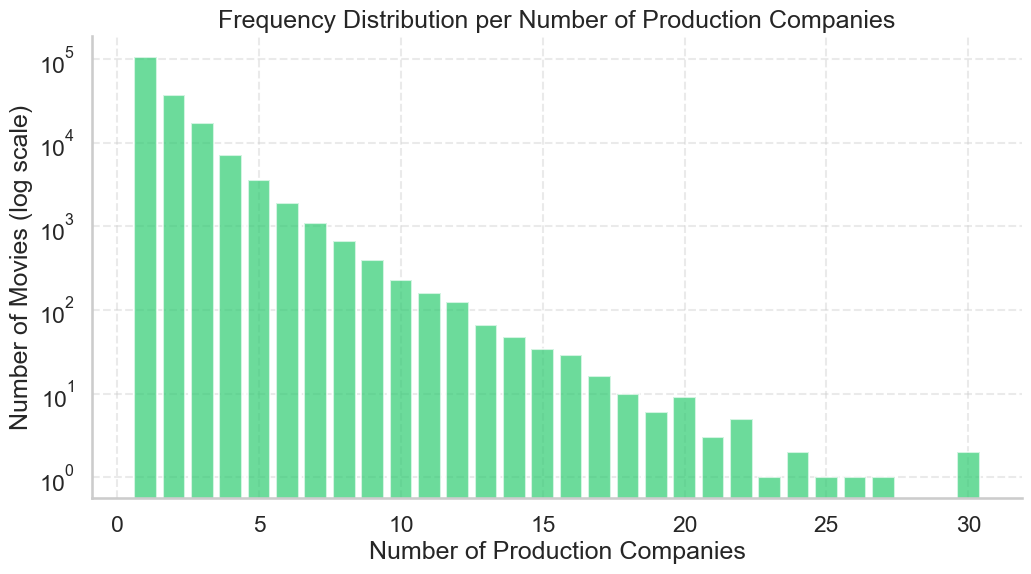

In [ ]:
company_counts = company_counts[company_counts.index > 0]
plt.figure(figsize=(12, 6))
plt.bar(company_counts.index, company_counts.values, color='#2ecc71', alpha=0.7, edgecolor='white')

plt.yscale('log')
style_plot('Frequency Distribution per Number of Production Companies', 'Number of Production Companies', 'Number of Movies (log scale)', False)

 Interestingly, there are a high number of movies with more than one production company. Production companies have the resources (creative or financial) to make the movies possible. It would be interesting to see how the number of production companies per movie has evolved over time. 

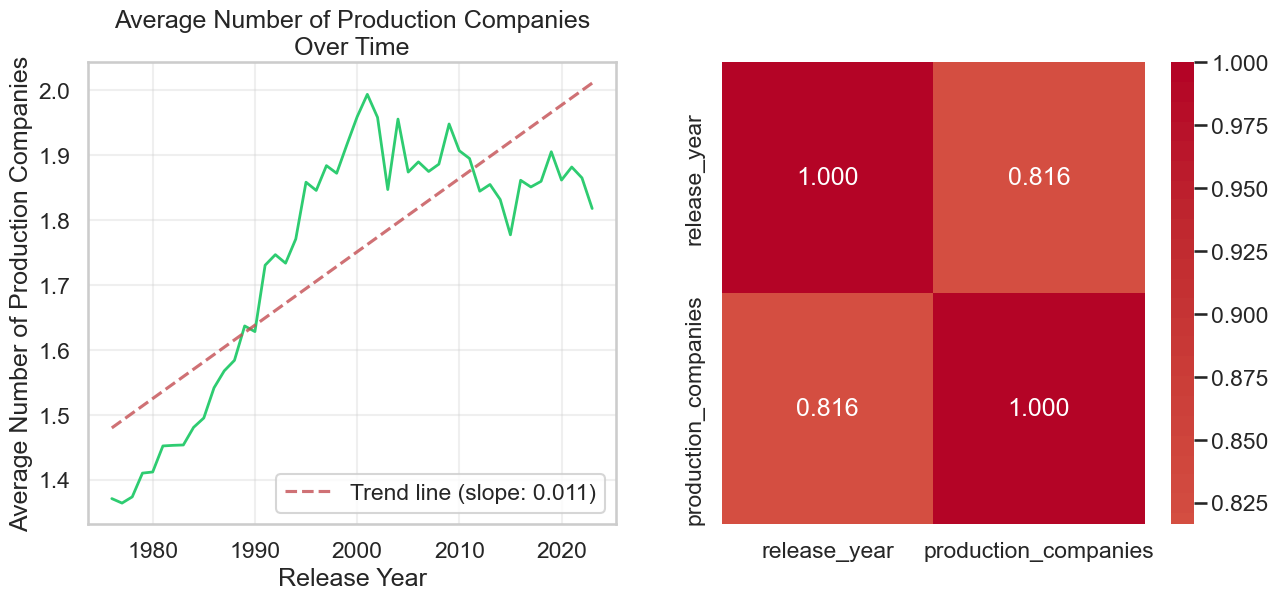

In [ ]:
# Get mean number of production companies per year
yearly_avg_companies = (df[df['production_companies'].str.len() > 0].groupby('release_year')
                       .agg({'production_companies': lambda x: x.str.len().mean()})
                       .reset_index())

# Create 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot mean number of production companies per year
ax1.plot(yearly_avg_companies['release_year'], 
             yearly_avg_companies['production_companies'],
             linewidth=2,
             color='#2ecc71')

# Add linear fit to the plot 
z = np.polyfit(yearly_avg_companies['release_year'], 
               yearly_avg_companies['production_companies'], 1)
p = np.poly1d(z)
ax1.plot(yearly_avg_companies['release_year'], 
         p(yearly_avg_companies['release_year']), 
         "r--", 
         alpha=0.8,
             label=f'Trend line (slope: {z[0]:.3f})')

ax1.set_title('Average Number of Production Companies\nOver Time')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Average Number of Production Companies')
ax1.grid(True, alpha=0.3)
ax1.legend()
    
correlation = yearly_avg_companies['release_year'].corr(yearly_avg_companies['production_companies'])
covariance = yearly_avg_companies['release_year'].cov(yearly_avg_companies['production_companies'])

# Plot correlation between number of production companies and release year
sns.heatmap(yearly_avg_companies.corr(), 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.3f',
                ax=ax2)
plt.show()


From this initial analysis, there is a strong correlation between the number of production companies per movie and the release year. 

In [ ]:
print(df['production_companies'].explode().value_counts().describe())

count    87170.000000
mean         3.613812
std         18.185170
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1439.000000
Name: count, dtype: float64


We then plot the number of movies produced per production company, considering production companies in decreasing order in terms of how many movies they produce. We use a log-log scale and notice a power law trend.

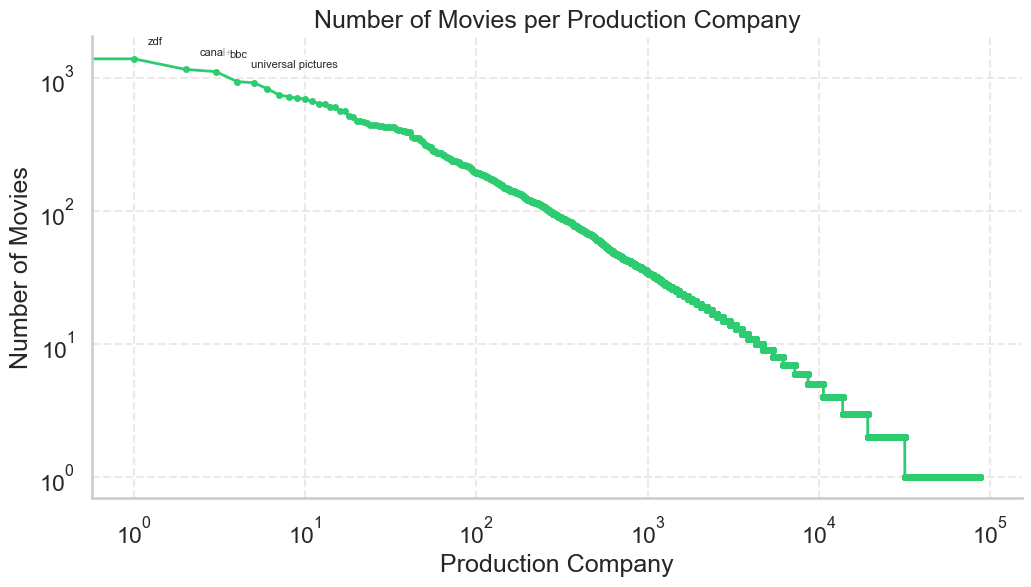

In [ ]:
plot_movie_freq_per_production_company(df)

This plot here shows us the number of movies each production company has produced. Notice that there are huge differences in the number of movies produced by each production company and clear 'dominance' of a few production companies. Let's look at those dominant production compnaies by looking atthe top 100 production companies. 

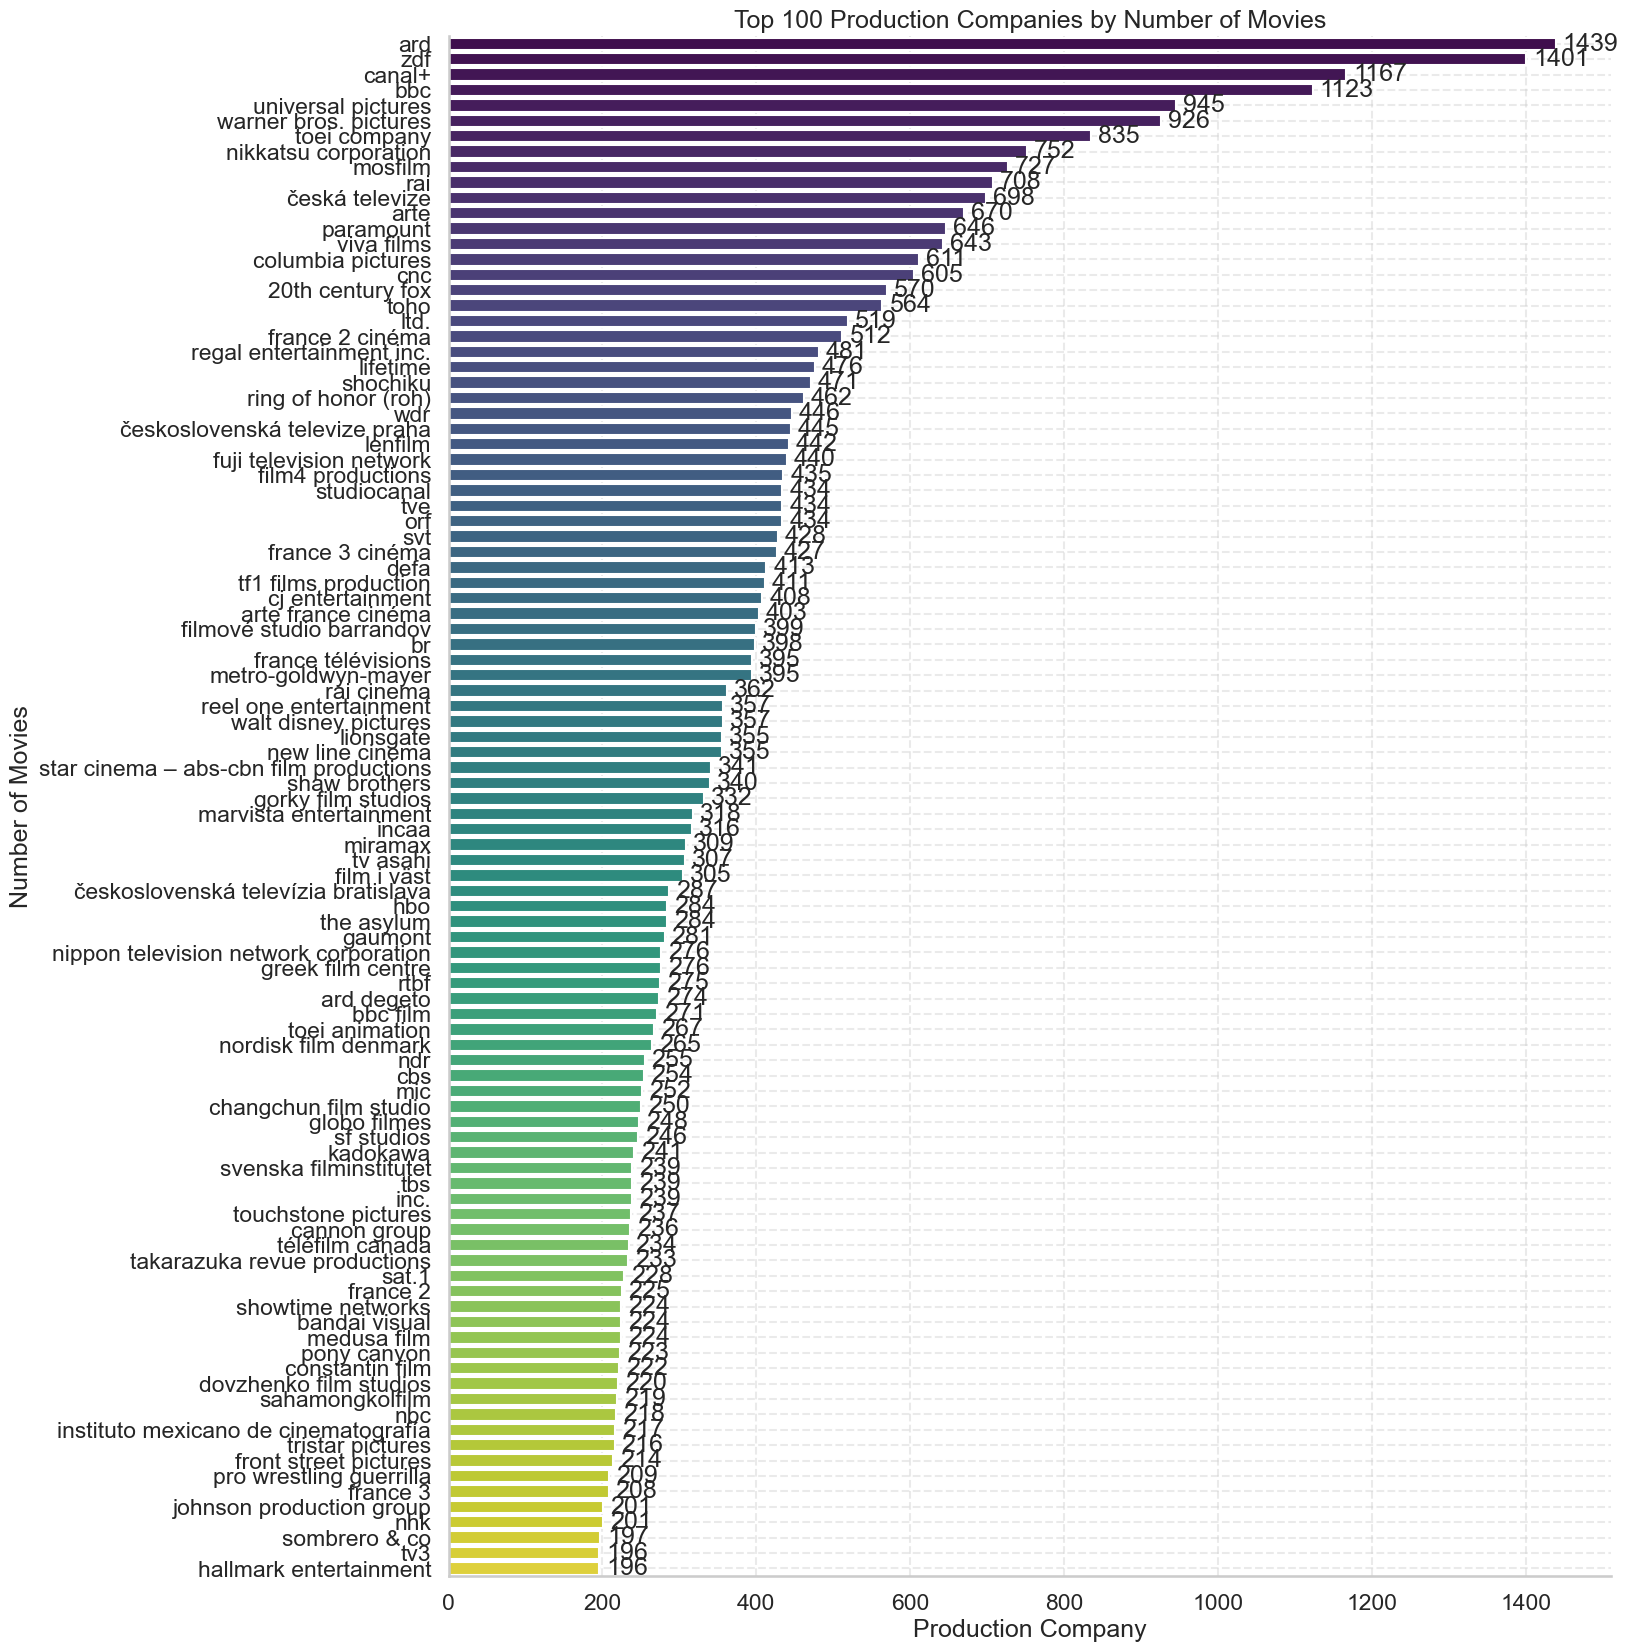

In [ ]:
# Get number of movies produced by top 100 production companies
top_100_companies = df['production_companies'].explode().value_counts().head(100)

# plot the values 
plt.figure(figsize=(15, 20))

ax = sns.barplot(
    y=top_100_companies.index,
    x=top_100_companies.values,
    palette='viridis',
    hue=top_100_companies.index,
    legend=False
)
for i in ax.containers:
    ax.bar_label(i, padding=5)
ax.grid(axis='x', linestyle='--', alpha=0.7)
style_plot('Top 100 Production Companies by Number of Movies', 'Production Company', 'Number of Movies', False)

There are some production companies that have a very high number of movies for P3 it would be interesting to find out why they are so successful 

# Runtime overview

We get an overview of the movie runtimes, excluding movies that do not have a runtime associated

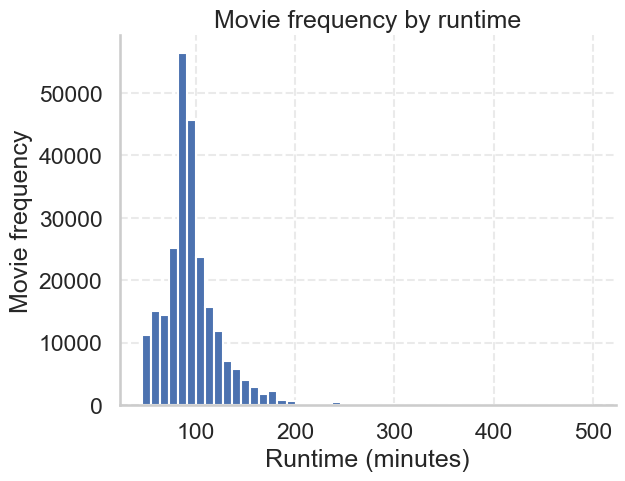

In [ ]:
# General runtime distribution
plt.hist(df[(df['runtime'] > 0)]['runtime'], bins=50)
style_plot(title='Movie frequency by runtime', xlabel='Runtime (minutes)', ylabel='Movie frequency')

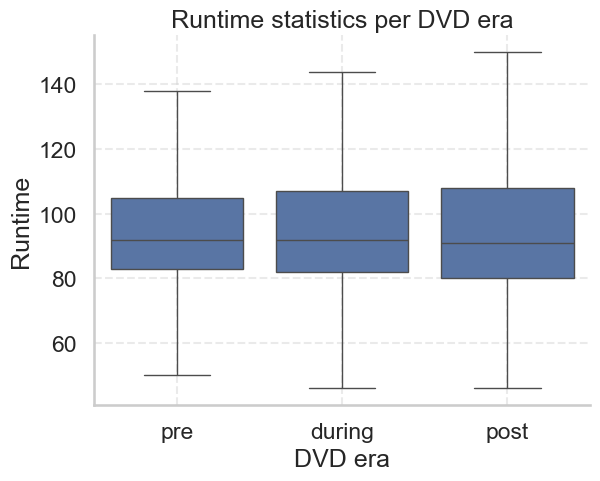

In [ ]:
# Runtime statistics in boxplot 
sns.boxplot(x='dvd_era', y='runtime', data=df[df['runtime'] > 0], showfliers=False, order=['pre', 'during', 'post'])
style_plot(title='Runtime statistics per DVD era', xlabel='DVD era', ylabel='Runtime')

In [ ]:
df[df.runtime >0].groupby('dvd_era')['runtime'].describe().reindex(['pre', 'during', 'post']).transpose()

dvd_era,pre,during,post
count,60259.000000,83718.000000,103082.000000
mean,96.264774,97.605007,97.573864
std,29.555468,32.726680,34.203319
min,46.000000,46.000000,46.000000
25%,83.000000,82.000000,80.000000
50%,92.000000,92.000000,91.000000
75%,105.000000,107.000000,108.000000
max,500.000000,500.000000,500.000000


There does not seem to be considerable differences in runtime statistics across the DVD eras. 

# Genre overview
For each DVD era, we obtain the top-10 movie genres based on the proportion of movies.


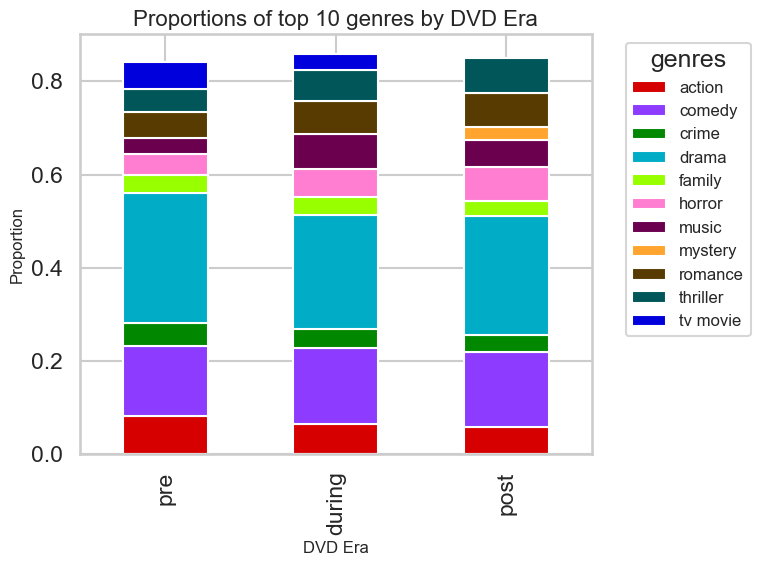

In [ ]:
top_10_genre =top_proportions_per_era(df, 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

We can see that drama is the most common genre across all eras, closely followed by comedy. We also see that the proportion of movies per genre stays relatively stable, except for TV Movies that disappear from the top 10 and Mystery movies that become more common in the post-DVD era. We need to examine these trends more closely and use statistical tests to determine if there are significant differences between DVD eras. 

# Theme extraction

For the major genres, we use LDA to extract the main topics in movies of the genre, with the goal of checking whether the main topics change overtime. Here is an example of topic extraction for the Drama movie genre, which appears to be the most common genre in the plot above. 

In [ ]:
# Pre-process movie plots, lowercase, removing stopwords & special characters
df['clean_overview'] = df.overview.apply(clean_text)

# Extract plots for Drama genre and pre-DVD era
text_data = get_movie_plots(df, 'drama', 'pre')
# Extract 3 main topics 
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/charlottemeyer/nltk_data'
    - '/Users/charlottemeyer/Documents/EPFL - Applied Data Analysis/ada-2024-project-databand/.conda/nltk_data'
    - '/Users/charlottemeyer/Documents/EPFL - Applied Data Analysis/ada-2024-project-databand/.conda/share/nltk_data'
    - '/Users/charlottemeyer/Documents/EPFL - Applied Data Analysis/ada-2024-project-databand/.conda/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


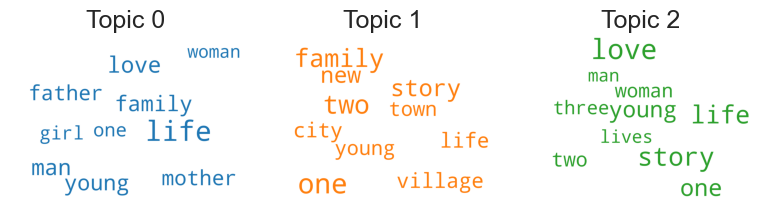

In [ ]:
text_data = get_movie_plots(df, 'drama', 'during')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

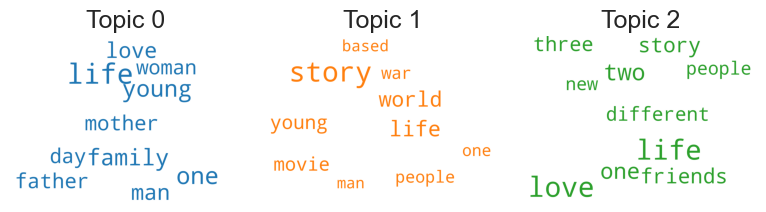

In [ ]:
text_data = get_movie_plots(df, 'drama', 'post')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

# Special types of movies
## Remakes 


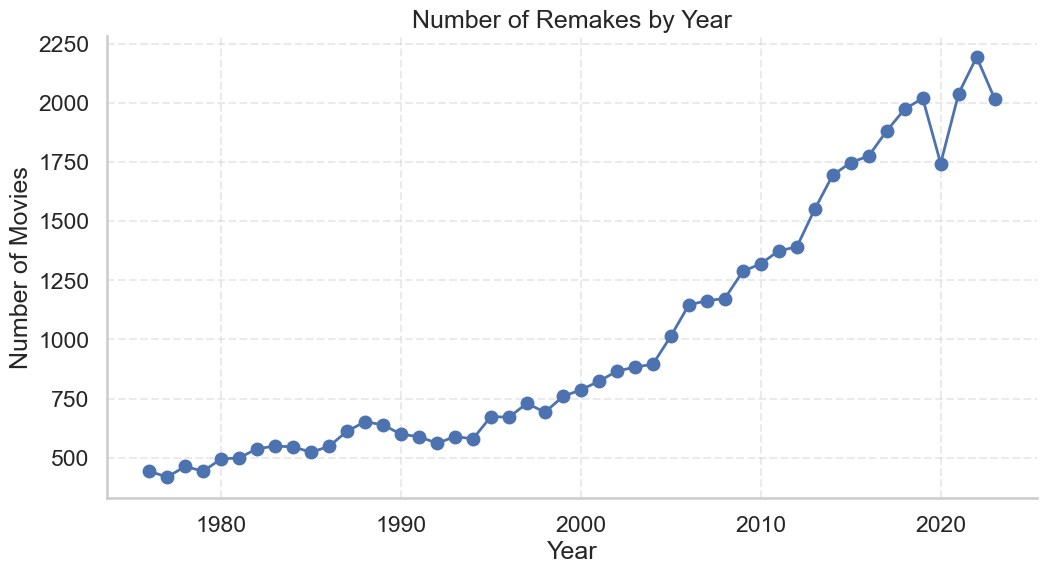

In [ ]:
remakes = (df.groupby('title')
           .agg({'release_year': ['count']}) # count for each year the number of times the same title appears
           .reset_index())

remakes = remakes[remakes[('release_year', 'count')] > 1] # Ensure we only keep titles that appear multiple times

yearly_remakes = (df[df['title'].isin(remakes['title'])]
                 .groupby('release_year')
                 .size())

plt.figure(figsize=(12, 6))
plt.plot(yearly_remakes.index, yearly_remakes.values, 
         marker='o', 
         linewidth=2)
style_plot('Number of Remakes by Year', 'Year', 'Number of Movies', False)

In [ ]:
remakes.head()

,title,release_year
,,count
66,#,2
266,'twas the night before christmas,2
350,+1,2
369,.,3
506,1,4


In [ ]:
print(remakes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16837 entries, 66 to 329564
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   (title, )              16837 non-null  object
 1   (release_year, count)  16837 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 394.6+ KB
None
